
# M2 ROM — Tiny RBM Lab (1D Reaction–Diffusion)

**Goal**: get a hands-on feel for Reduced Basis Methods (RBM) on a tiny 1D problem with an affine parameter dependence.
You will:

generate snapshots and build a POD basis (Exercise 1),
implement a residual-based a posteriori error estimator (Exercise 2),
implement a greedy basis selection (Exercise 3).
**Model problem (finite-difference)**: find $u(x;\mu)$ on $x\in(0,1)$ s.t.
$$
-\mu,u''(x) + u(x) = 1,\quad u(0)=u(1)=0,\quad \mu\in[0.1,10].
$$

Discretization with $N$ interior points gives the linear system
$$
(\mu K + I),\mathbf{u} = \mathbf{f},
$$
where $K$ is the 1D Laplacian (Dirichlet) stiffness matrix and $I$ is the identity.
This affine form $A(\mu)=\mu K + I$ enables a clean offline/online split.

Residual-based estimator (Euclidean norm):
Let $\mathbf{r}(\mu) = \mathbf{f} - A(\mu)\mathbf{u}N(\mu)$. For SPD problems,
$$
|\mathbf{u}(\mu)-\mathbf{u}N(\mu)|2 \le \frac{|\mathbf{r}(\mu)|2}{\alpha_{LB}(\mu)}.
$$
For our choice $A(\mu)=\mu K + I$, a valid coercivity lower bound is
$$
\alpha_{LB}(\mu) = \mu,\lambda{\min}(K) + 1,
$$
where
$$
\lambda{\min}(K) = \frac{4}{h^2}\sin^2!\Big(\frac{\pi}{2(N+1)}\Big),\qquad h=\frac{1}{N+1}.
$$

**What you'll see**: Error vs. basis size for POD and for Greedy; effectivity ($\Delta/|e|$) of the estimator; and a simple offline/online timing.



## Setup


In [1]:

import numpy as np
import matplotlib.pyplot as plt
import time

# Problem size and parameter range
N = 32                    # interior points
MU_TRAIN = np.logspace(np.log10(0.1), np.log10(10), 20)   # 20 training params
MU_TEST  = np.logspace(np.log10(0.1), np.log10(10), 50)   # 50 test params

print(f"Problem size: N={N}")
print(f"Training parameters: {len(MU_TRAIN)}")
print(f"Test parameters: {len(MU_TEST)}")


Problem size: N=32
Training parameters: 20
Test parameters: 50



## Core Functions

Here are the core functions you'll need for the exercises.


In [2]:

def assemble_system(N):
    """
    Build 1D matrices for -mu u'' + u = 1 with Dirichlet BCs on (0,1).
    Returns:
        K  : (N,N) Laplacian stiffness (finite-difference) with scaling 1/h^2
        I  : (N,N) identity
        f  : (N,)   RHS vector of ones
        h  : grid spacing
        lminK : smallest eigenvalue of K (analytical formula)
    """
    h = 1.0/(N+1)
    main = 2.0*np.ones(N)
    off  = -1.0*np.ones(N-1)
    K = (1.0/h**2)*(np.diag(main) + np.diag(off, 1) + np.diag(off, -1))
    I = np.eye(N)
    f = np.ones(N)

    # Exact smallest eigenvalue of 1D Dirichlet Laplacian matrix
    lminK = (4.0/(h**2))*(np.sin(np.pi/(2.0*(N+1)))**2)
    return K, I, f, h, lminK


def solve_full(mu, K, I, f):
    """Solve the full-order system (mu*K + I)*u = f."""
    A = mu*K + I
    u = np.linalg.solve(A, f)
    return u


def rb_solve(mu, U, K, I, f):
    """
    Reduced-basis solve: project onto span(U) and solve reduced system.
    Returns u_rb (in full space) and coefficients a.
    """
    # Reduced matrices/vectors
    A_r = U.T @ (mu*K + I) @ U
    f_r = U.T @ f
    
    # Solve reduced system
    a = np.linalg.solve(A_r, f_r)
    u_rb = U @ a
    return u_rb, a


def pod_basis(S, r):
    """
    Extract POD basis of size r from snapshot matrix S.
    Returns U (POD basis) and s (singular values).
    """
    U_full, s, Vt = np.linalg.svd(S, full_matrices=False)
    U = U_full[:, :r]
    return U, s


def project_error(u_full, u_rb):
    """
    Compute projection error ||u_full - u_rb||_2 and relative error.
    """
    err = np.linalg.norm(u_full - u_rb, 2)
    rel = err / np.linalg.norm(u_full, 2)
    return err, rel


def alpha_LB(mu, lminK):
    """Coercivity lower bound for our problem A(mu) = mu*K + I."""
    return mu * lminK + 1.0


def estimator(u_rb, mu, K, I, f, lminK):
    """
    Residual-based a posteriori error estimator.
    Returns ||r||_2 / alpha_LB(mu).
    """
    r = f - (mu*K + I) @ u_rb
    residual_norm = np.linalg.norm(r, 2)
    alpha_lb = alpha_LB(mu, lminK)
    return residual_norm / alpha_lb


def orthonormalize(v, U=None, tol=1e-12):
    """
    Gram-Schmidt orthonormalization of v against columns of U.
    Returns orthonormalized vector or None if linearly dependent.
    """
    w = v.copy()
    if U is not None:
        for j in range(U.shape[1]):
            w -= (U[:, j].T @ w) * U[:, j]
    nrm = np.linalg.norm(w, 2)
    if nrm < tol:
        return None  # dependent vector
    return w / nrm



## Exercise 1 — POD basis construction (10 min)

Build a snapshot matrix and compute its POD (SVD). Plot the singular values and cumulative energy.

**Tasks:**
1. Build snapshot matrix `S` by computing full solutions for all training parameters
2. Compute POD basis using SVD
3. Plot singular values (semilogy) and cumulative energy
4. Find how many modes capture 99% and 99.9% of energy

> *Hint:* Use `solve_full`, `pod_basis`. Cumulative energy = `np.cumsum(s**2) / np.sum(s**2)`


=== Exercise 1 Results ===
Snapshot matrix shape: (32, 20)
Number of training parameters: 20
Modes capturing 99% energy:   1
Modes capturing 99.9% energy: 1


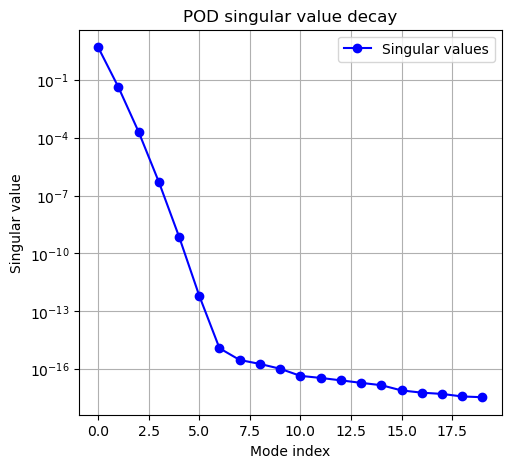

In [3]:

# === Your turn (student cell) ===
# Build snapshot matrix, compute POD, and analyze singular values

# Set up problem matrices
K, I, f, h, lminK = assemble_system(N)

# TODO: Build snapshot matrix S
# Hint: S should be (N, len(MU_TRAIN)) where each column is solve_full(mu, K, I, f)
S = np.column_stack([solve_full(mu, K, I, f) for mu in MU_TRAIN])

# TODO: Compute POD basis
# Hint: U_full, s, Vt = np.linalg.svd(S, full_matrices=False)
U_full, s, Vt = np.linalg.svd(S, full_matrices=False)

# TODO: Plot singular values and cumulative energy
# Create subplots and plot:
# 1) semilogy plot of singular values
# 2) cumulative energy plot with 99% and 99.9% lines

cumulative_energy = np.cumsum(s**2) / np.sum(s**2)
plt.figure(figsize=(12,5))

# (1) Singular values
plt.subplot(1,2,1)
plt.semilogy(s, 'bo-', label='Singular values')
plt.xlabel('Mode index')
plt.ylabel('Singular value')
plt.title('POD singular value decay')
plt.grid(True)
plt.legend()

# TODO: Find modes for 99% and 99.9% energy
# Hint: Use np.argmax(cumulative_energy >= 0.99) + 1
modes_99 = np.argmax(cumulative_energy >= 0.99) + 1
modes_999 = np.argmax(cumulative_energy >= 0.999) + 1

print("=== Exercise 1 Results ===")
# Print your results here
print(f"Snapshot matrix shape: {S.shape}")
print(f"Number of training parameters: {len(MU_TRAIN)}")
print(f"Modes capturing 99% energy:   {modes_99}")
print(f"Modes capturing 99.9% energy: {modes_999}")



## Exercise 2 — Residual-based estimator & effectivity (10–15 min)

Using the POD basis of size $r=10$:
1. For each $\mu\in$ `MU_TEST`, compute the reduced solution and the **estimator**
   $\Delta(\mu) = \|\mathbf{r}\|_2/\alpha_{LB}(\mu)$.
2. Compute the **true error** $ \|e(\mu)\|_2 $ and the **effectivity** $ \eta(\mu) = \Delta(\mu)/\|e(\mu)\|_2 $.
3. Plot $\eta(\mu)$ versus $\mu$. You should get $\eta(\mu)\gtrsim 1$.

> *Hint:* see `alpha_LB`, `estimator`, and `project_error`.


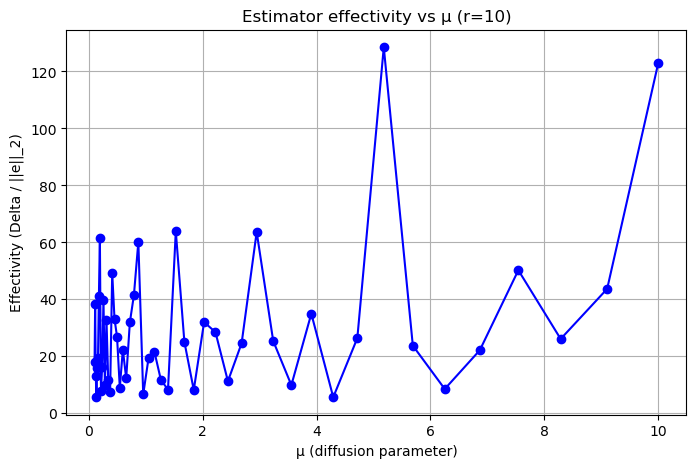

=== Exercise 2 Results ===
Min effectivity : 5.659
Max effectivity : 128.508
Mean effectivity: 29.592


In [4]:

# === Your turn (student cell) ===
# Compute estimator effectivity for POD basis of size r=10

# TODO: Build POD basis of size r=10
r = 10
# Hint: U_r, s = pod_basis(S, r)
U_r, s_pod = pod_basis(S, r)

# TODO: Compute effectivity for each test parameter
effectivities = []
errors = []
# Hint: For each mu in MU_TEST:
#   1) Compute full solution: u_full = solve_full(mu, K, I, f)
#   2) Compute reduced solution: u_rb, a = rb_solve(mu, U_r, K, I, f)
#   3) Compute estimator: Delta = estimator(u_rb, mu, K, I, f, lminK)
#   4) Compute true error: err, _ = project_error(u_full, u_rb)
#   5) Compute effectivity: Delta/err
for mu in MU_TEST:
    u_full = solve_full(mu, K, I, f)
    u_rb, a = rb_solve(mu, U_r, K, I, f)
    Delta = estimator(u_rb, mu, K, I, f, lminK)
    err, _ = project_error(u_full, u_rb)
    effectivities.append(Delta / err)
    errors.append(err)

# TODO: Plot effectivity vs mu
# plt.figure()
# plt.plot(MU_TEST, effectivities, marker='o')
# plt.xlabel("mu")
# plt.ylabel("Effectivity (Delta / ||e||_2)")
# plt.title("Estimator effectivity vs mu (r=10)")
# plt.grid(True)
# plt.show()
plt.figure(figsize=(8,5))
plt.plot(MU_TEST, effectivities, marker='o', color='b')
plt.xlabel("μ (diffusion parameter)")
plt.ylabel("Effectivity (Delta / ||e||_2)")
plt.title("Estimator effectivity vs μ (r=10)")
plt.grid(True)
plt.show()

print("=== Exercise 2 Results ===")
# Print statistics about effectivity (min, max, mean)
effectivities = np.array(effectivities)
print(f"Min effectivity : {effectivities.min():.3f}")
print(f"Max effectivity : {effectivities.max():.3f}")
print(f"Mean effectivity: {effectivities.mean():.3f}")



## Exercise 3 — Greedy basis construction (15–20 min)

Implement a greedy that selects $\mu_k$ by **maximizing** the estimator over the training set,
and enriches the basis with the **full-order** solution at $\mu_k$. Stop when the max estimator
falls below a tolerance or when you reach a max size.

**Algorithm:**
1. Initialize with one parameter (middle of training set)
2. **Loop:** Compute estimator for all training parameters, select max
3. **Enrich:** Add full solution at selected parameter to basis
4. **Orthonormalize:** Use Gram-Schmidt
5. **Check:** Stop if estimator < tol or max basis size reached

> *Hint:* Use `estimator`, `solve_full`, `orthonormalize`, `rb_solve`


[Greedy] Starting with mu=1.129
[Greedy] Iteration 1: max estimator = 4.861e-01 at mu = 0.100
[Greedy] Iteration 2: max estimator = 5.031e-03 at mu = 0.162
[Greedy] Iteration 3: max estimator = 1.783e-05 at mu = 0.264
[Greedy] Iteration 4: max estimator = 4.834e-08 at mu = 0.127
[Greedy] Converged at iteration 4


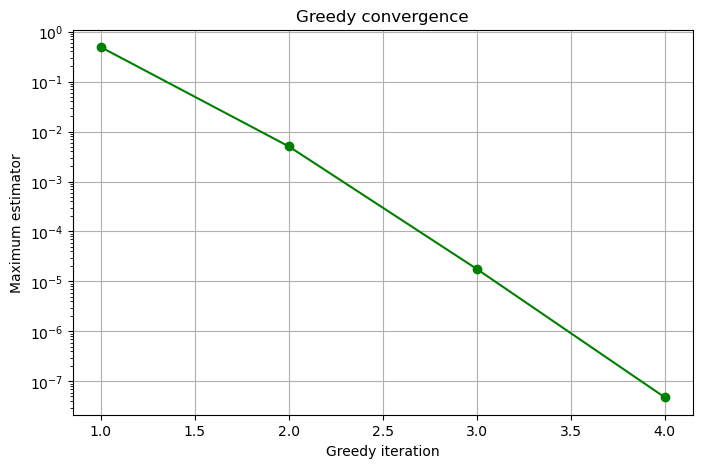

=== Exercise 3 Results ===
Final basis size: 4
Selected parameters (μ): [0.1        0.16237767 0.26366509]


In [5]:

# === Your turn (student cell) ===
# Implement greedy basis construction

def greedy_algorithm(mu_train, K, I, f, lminK, tol=1e-6, max_basis=15, verbose=True):
    """
    Greedy algorithm for basis construction.
    
    Returns:
        U: basis matrix
        selected_params: list of selected parameters
        estimator_history: list of max estimators per iteration
    """
    # TODO: Initialize with middle parameter
    # Hint: mu0 = mu_train[len(mu_train)//2]
    # Hint: u0 = solve_full(mu0, K, I, f)
    # Hint: U = orthonormalize(u0, None)[:, None]
    mu0 = mu_train[len(mu_train)//2]
    u0 = solve_full(mu0, K, I, f)
    v0 = orthonormalize(u0, None)[:, None]
    
    U = v0
    
    selected_params = []  # TODO: Initialize with mu0
    estimator_history = []
    
    if verbose:
        print(f"[Greedy] Starting with mu={mu0:.3f}")
    
    # TODO: Main greedy loop
    for iteration in range(1, max_basis + 1):
        # TODO: Compute estimator for all training parameters
        estimators = []
        # for mu in mu_train:
        #     u_rb, _ = rb_solve(mu, U, K, I, f)
        #     est = estimator(u_rb, mu, K, I, f, lminK)
        #     estimators.append(est)
        for mu in mu_train:
            u_rb, _ = rb_solve(mu, U, K, I, f)
            est = estimator(u_rb, mu, K, I, f, lminK)
            estimators.append(est)
        
        # TODO: Find parameter with maximum estimator
        # Hint: idx = np.argmax(estimators)
        # Hint: mu_star = mu_train[idx]
        # Hint: max_estimator = estimators[idx]
        idx = np.argmax(estimators)
        mu_star = mu_train[idx]
        max_estimator = estimators[idx]
        
        estimator_history.append(max_estimator)
        
        if verbose:
            print(f"[Greedy] Iteration {iteration}: max estimator = {max_estimator:.3e} at mu = {mu_star:.3f}")
        
        # TODO: Check stopping criterion
        # if max_estimator < tol:
        #     break
        if max_estimator < tol:
            if verbose:
                print(f"[Greedy] Converged at iteration {iteration}")
            break
        
        # TODO: Enrich basis with solution at mu_star
        # Hint: u_star = solve_full(mu_star, K, I, f)
        # Hint: v_new = orthonormalize(u_star, U)
        # if v_new is None:  # linearly dependent
        #     break
        # Hint: U = np.column_stack([U, v_new])
        u_star = solve_full(mu_star, K, I, f)
        v_new = orthonormalize(u_star, U)
        if v_new is None:  # linearly dependent
            if verbose:
                print(f"[Greedy] Linear dependence at iteration {iteration}")
            break
        U = np.column_stack([U, v_new])
        
        selected_params.append(mu_star)
    
    return U, np.array(selected_params), np.array(estimator_history)

# TODO: Run the greedy algorithm
# U_greedy, selected, history = greedy_algorithm(MU_TRAIN, K, I, f, lminK, tol=1e-6, max_basis=15)
U_greedy, selected, history = greedy_algorithm(MU_TRAIN, K, I, f, lminK, tol=1e-6, max_basis=15)


# TODO: Plot greedy convergence
# plt.figure()
# plt.semilogy(range(1, len(history)+1), history, 'o-')
# plt.xlabel('Greedy iteration')
# plt.ylabel('Maximum estimator')
# plt.title('Greedy convergence')
# plt.grid(True)
# plt.show()
plt.figure(figsize=(8,5))
plt.semilogy(range(1, len(history)+1), history, 'o-', color='green')
plt.xlabel('Greedy iteration')
plt.ylabel('Maximum estimator')
plt.title('Greedy convergence')
plt.grid(True)
plt.show()

print("=== Exercise 3 Results ===")
# Print final basis size and selected parameters
print(f"Final basis size: {U_greedy.shape[1]}")
print(f"Selected parameters (μ): {selected}")



## Exercise 4 — POD vs Greedy comparison (10 min)

Compare POD and Greedy methods by computing the mean relative error on the test set for different basis sizes.

> *Hint:* For fair comparison, use same range of basis sizes (1 to min(POD_size, Greedy_size))


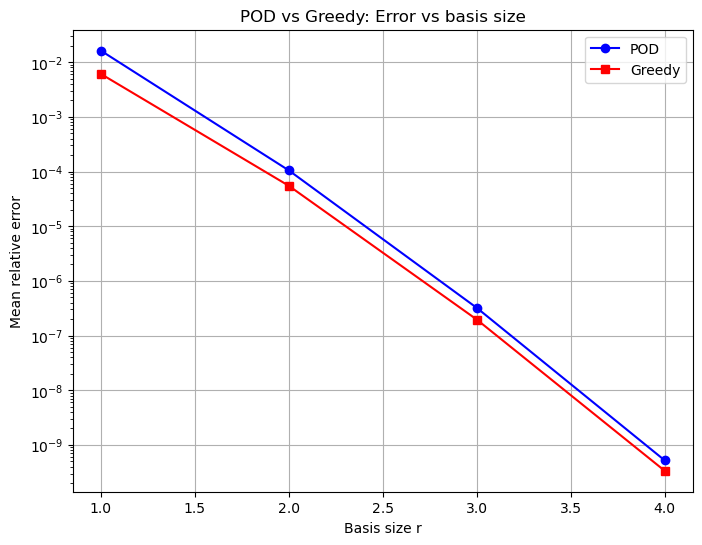

=== Exercise 4 Results ===
r =  1 | Mean RelErr (POD) = 1.617e-02 | (Greedy) = 6.072e-03
r =  2 | Mean RelErr (POD) = 1.047e-04 | (Greedy) = 5.473e-05
r =  3 | Mean RelErr (POD) = 3.218e-07 | (Greedy) = 1.965e-07
r =  4 | Mean RelErr (POD) = 5.238e-10 | (Greedy) = 3.379e-10


In [6]:

# === Your turn (student cell) ===
# Compare POD vs Greedy methods

# TODO: Test both methods for different basis sizes
basis_sizes = range(1, min(U_greedy.shape[1], 15) + 1)
pod_errors = []
greedy_errors = []

for r in basis_sizes:
    # TODO: Extract basis of size r for both methods
    # U_pod_r = ...
    # U_greedy_r = ...
    U_pod_r = U_full[:, :r]
    U_greedy_r = U_greedy[:, :r]
    
    # TODO: Compute mean relative error on test set
    # pod_test_errors = []
    # greedy_test_errors = []
    # for mu in MU_TEST:
    #     # Compute errors for both methods
    #     pass
    
    # pod_errors.append(np.mean(pod_test_errors))
    # greedy_errors.append(np.mean(greedy_test_errors))
    pod_test_errors = []
    greedy_test_errors = []

    for mu in MU_TEST:
        # Compute full solution
        u_full = solve_full(mu, K, I, f)

        # POD error
        u_pod, _ = rb_solve(mu, U_pod_r, K, I, f)
        _, rel_pod = project_error(u_full, u_pod)
        pod_test_errors.append(rel_pod)

        # Greedy error
        u_greedy, _ = rb_solve(mu, U_greedy_r, K, I, f)
        _, rel_greedy = project_error(u_full, u_greedy)
        greedy_test_errors.append(rel_greedy)

    pod_errors.append(np.mean(pod_test_errors))
    greedy_errors.append(np.mean(greedy_test_errors))

# TODO: Plot comparison
# plt.figure()
# plt.semilogy(basis_sizes, pod_errors, 'b-o', label='POD')
# plt.semilogy(basis_sizes, greedy_errors, 'r-s', label='Greedy')
# plt.xlabel('Basis size')
# plt.ylabel('Mean relative error')
# plt.title('POD vs Greedy: Error vs basis size')
# plt.legend()
# plt.grid(True)
# plt.show()
plt.figure(figsize=(8,6))
plt.semilogy(basis_sizes, pod_errors, 'b-o', label='POD')
plt.semilogy(basis_sizes, greedy_errors, 'r-s', label='Greedy')
plt.xlabel('Basis size r')
plt.ylabel('Mean relative error')
plt.title('POD vs Greedy: Error vs basis size')
plt.legend()
plt.grid(True)
plt.show()

print("=== Exercise 4 Results ===")
# Print comparison summary
for r, ep, eg in zip(basis_sizes, pod_errors, greedy_errors):
    print(f"r = {r:2d} | Mean RelErr (POD) = {ep:.3e} | (Greedy) = {eg:.3e}")



## Summary and Reflection

**Key Takeaways:**
1. **POD**: Optimal in terms of energy, but requires all snapshots upfront
2. **Greedy**: Adaptive selection, can be more efficient for sparse parameter exploration
3. **Estimators**: Provide computable error bounds for certification
4. **Offline/Online**: ROM enables fast parameter sweeps after offline preprocessing

**Questions to consider:**
- Which method converges faster for your problem?
- How tight are the error estimator bounds?
- What happens with different parameter ranges or problem sizes?
- How do computational costs compare?
- Can we accelerate the offline/online procedure ?

**Extensions you could try:**
- Different parameter distributions (uniform vs logarithmic)
- Multiple parameters (2D, 3D parameter spaces)
- Different PDEs or boundary conditions
- Advanced greedy variants (POD-Greedy, hp-adaptation)


## Extended Problem with Oscillating Source Term

Let's extend the PDE to include an oscillating source term:

$$-\mu u'' + u = 1 + \nu \sin(\omega \pi x)$$

where:
- $\mu$ is the diffusion parameter (as before)
- $\nu$ is the amplitude of the oscillating source  
- $\omega$ is the frequency of the oscillation

This creates a 2-parameter problem $(\mu, \nu)$ with the frequency $\omega$ potentially being a third parameter.

In [9]:
def assemble_system_extended(N, omega=2.0):
    """
    Build 1D matrices for -mu u'' + u = 1 + nu*sin(omega*pi*x) with Dirichlet BCs on (0,1).
    
    This uses affine decomposition:
    (mu*K + I) u = f_base + nu*f_osc
    
    Parameters:
        N: number of interior grid points
        omega: frequency parameter for oscillating source
    
    Returns:
        K  : (N,N) Laplacian stiffness matrix
        I  : (N,N) identity matrix  
        f_base : (N,) base RHS vector (constant source)
        f_osc  : (N,) oscillating RHS vector (sin source)
        h  : grid spacing
        lminK : smallest eigenvalue of K
    """
    h = 1.0/(N+1)
    main = 2.0*np.ones(N)
    off  = -1.0*np.ones(N-1)
    K = (1.0/h**2)*(np.diag(main) + np.diag(off, 1) + np.diag(off, -1))
    I = np.eye(N)
    
    # Base RHS (constant source)
    f_base = np.ones(N)
    
    # Oscillating RHS: sin(omega*pi*x) at interior grid points
    x_interior = np.linspace(h, 1-h, N)  # x_i = i*h for i=1,...,N
    f_osc = np.sin(omega * np.pi * x_interior)
    
    # Exact smallest eigenvalue of 1D Dirichlet Laplacian matrix  
    lminK = (4.0/(h**2))*(np.sin(np.pi/(2.0*(N+1)))**2)
    
    return K, I, f_base, f_osc, h, lminK


def solve_full_extended(mu, nu, K, I, f_base, f_osc):
    """
    Solve (mu*K + I) u = f_base + nu*f_osc.
    
    Parameters:
        mu: diffusion parameter
        nu: oscillating source amplitude
        K, I: system matrices
        f_base, f_osc: RHS vectors
    """
    A = mu*K + I
    f_total = f_base + nu*f_osc
    return np.linalg.solve(A, f_total)


def build_snapshots_extended(mu_vals, nu_vals, K, I, f_base, f_osc):
    """
    Build snapshot matrix for 2-parameter problem.
    Creates snapshots for all combinations of (mu, nu) values.
    
    Returns:
        S: (N, num_snapshots) matrix where num_snapshots = len(mu_vals) * len(nu_vals)
        param_combinations: list of (mu, nu) tuples corresponding to columns of S
    """
    snapshots = []
    param_combinations = []
    
    for mu in mu_vals:
        for nu in nu_vals:
            u = solve_full_extended(mu, nu, K, I, f_base, f_osc)
            snapshots.append(u)
            param_combinations.append((mu, nu))
    
    S = np.column_stack(snapshots)
    return S, param_combinations


def rb_solve_extended(mu, nu, U, K, I, f_base, f_osc):
    """
    Reduced solve for extended problem: (mu*U^T K U + U^T I U) a = U^T (f_base + nu*f_osc)
    """
    Kr = U.T @ K @ U
    Mr = U.T @ I @ U  # should be close to identity if U orthonormal
    fr_base = U.T @ f_base
    fr_osc = U.T @ f_osc
    
    Ar = mu*Kr + Mr
    fr_total = fr_base + nu*fr_osc
    a = np.linalg.solve(Ar, fr_total)
    return U @ a, a


print("✓ Extended multi-parameter functions defined!")

✓ Extended multi-parameter functions defined!


## Extended Exercises — Multi-Parameter Problem

Now that you have the extended problem setup, let's explore the 2-parameter space $(\mu, \nu)$ where:
- $\mu \in [0.1, 10]$ controls diffusion
- $\nu \in [-2, 2]$ controls oscillating source amplitude
- $\omega = 2$ is the fixed frequency

**Goal**: Apply ROM methods to this richer problem and see how the parameter space affects the basis construction.

### Exercise 5 — Parameter Space Exploration (10 min)

Explore the 2-parameter problem by visualizing solutions and understanding the parameter space structure.

**Tasks:**
1. Set up parameter ranges for $(\mu, \nu)$
2. Visualize a few solutions for different parameter combinations
3. Build snapshots for the 2-parameter problem
4. Analyze how solutions vary with both parameters

> *Hint:* Use `assemble_system_extended`, `solve_full_extended`, `build_snapshots_extended`

Extended problem setup:
  - Grid size: N = 32
  - Frequency: ω = 2.0
  - μ range: 8 values from 0.1 to 10.0
  - ν range: 6 values from -2.0 to 2.0
  - Total parameter combinations: 48


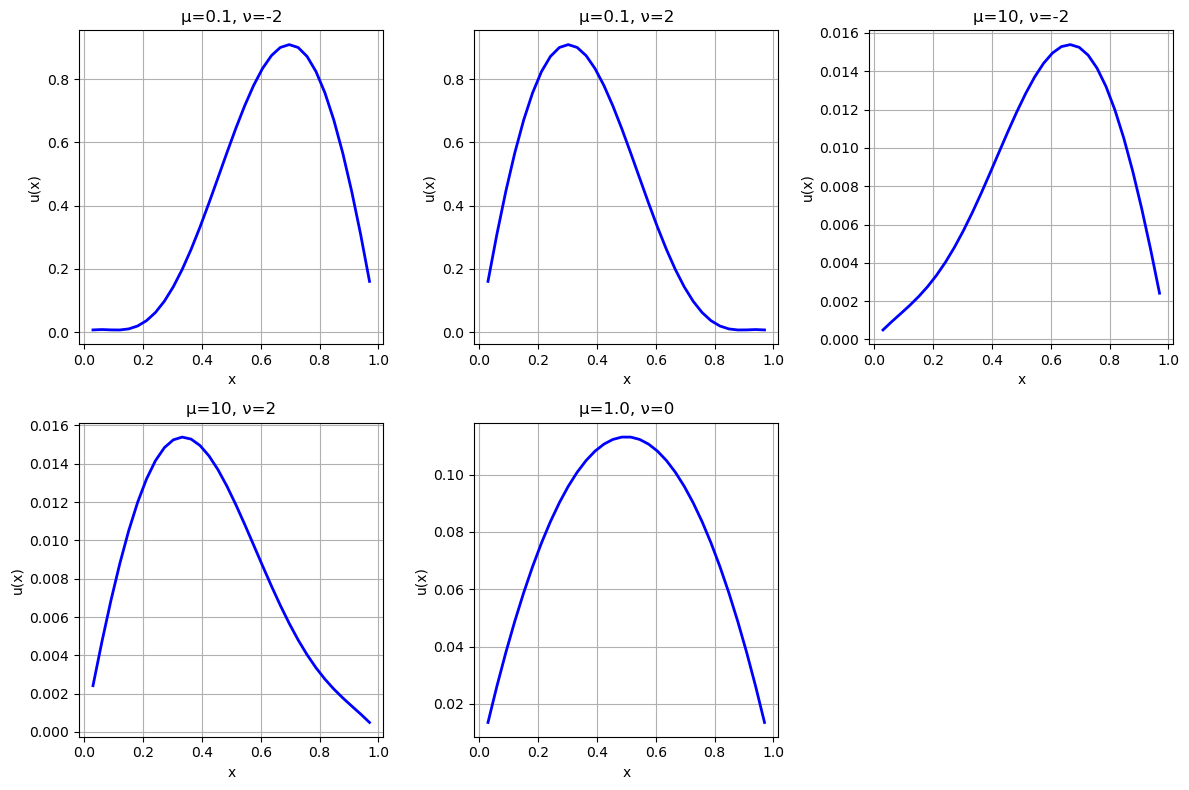


=== Exercise 5 Results ===
Snapshot matrix shape: (32, 48)
Total snapshots: 48
Solution range across all snapshots: min=0.000, max=0.909, mean=0.141


In [10]:
# === Your turn (student cell) ===
# Explore the 2-parameter problem space

# TODO: Set up the extended system
omega_freq = 2.0  # Fixed frequency
# K_ext, I_ext, f_base_ext, f_osc_ext, h_ext, lminK_ext = assemble_system_extended(N, omega_freq)
K_ext, I_ext, f_base_ext, f_osc_ext, h_ext, lminK_ext = assemble_system_extended(N, omega_freq)

# TODO: Define parameter ranges
# Hint: mu_ext = np.logspace(np.log10(0.1), np.log10(10), 8)    # 8 mu values
# Hint: nu_ext = np.linspace(-2, 2, 6)                          # 6 nu values
mu_ext = np.logspace(np.log10(0.1), np.log10(10), 8)
nu_ext = np.linspace(-2, 2, 6)

print(f"Extended problem setup:")
print(f"  - Grid size: N = {N}")
print(f"  - Frequency: ω = {omega_freq}")
print(f"  - μ range: {len(mu_ext)} values from {mu_ext[0]:.1f} to {mu_ext[-1]:.1f}")
print(f"  - ν range: {len(nu_ext)} values from {nu_ext[0]:.1f} to {nu_ext[-1]:.1f}")
print(f"  - Total parameter combinations: {len(mu_ext) * len(nu_ext)}")

# TODO: Visualize a few solutions for different parameter combinations
# Create a grid for visualization
x_ext = np.linspace(0, 1, N+2)[1:-1]  # Interior points

# Pick some interesting parameter combinations to visualize
param_demo = [(0.1, -2), (0.1, 2), (10, -2), (10, 2), (1.0, 0)]

plt.figure(figsize=(12, 8))
for i, (mu_demo, nu_demo) in enumerate(param_demo):
    # TODO: Solve for this parameter combination
    u_demo = solve_full_extended(mu_demo, nu_demo, K_ext, I_ext, f_base_ext, f_osc_ext)
    
    plt.subplot(2, 3, i+1)
    # TODO: Plot the solution
    # plt.plot(x_ext, u_demo, 'b-', linewidth=2)
    # plt.title(f'μ={mu_demo}, ν={nu_demo}')
    # plt.xlabel('x')
    # plt.ylabel('u(x)')
    # plt.grid(True)
    plt.plot(x_ext, u_demo, 'b-', linewidth=2)
    plt.title(f'μ={mu_demo}, ν={nu_demo}')
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.grid(True)

plt.tight_layout()
plt.show()

# TODO: Build snapshot matrix for the 2-parameter problem
S_ext, param_combinations_ext = build_snapshots_extended(mu_ext, nu_ext, K_ext, I_ext, f_base_ext, f_osc_ext)

print(f"\n=== Exercise 5 Results ===")
print(f"Snapshot matrix shape: {S_ext.shape}")
print(f"Total snapshots: {len(param_combinations_ext)}")
# Print some statistics about the solutions
max_val = np.max(S_ext)
min_val = np.min(S_ext)
mean_val = np.mean(S_ext)
print(f"Solution range across all snapshots: min={min_val:.3f}, max={max_val:.3f}, mean={mean_val:.3f}")

### Exercise 6 — POD for Multi-Parameter Problem (15 min)

Apply POD to the 2-parameter snapshot matrix and analyze the singular value decay.

**Tasks:**
1. Compute POD decomposition of the extended snapshot matrix
2. Plot singular values and analyze the decay rate
3. Compare energy content with the 1-parameter case
4. Visualize the first few POD modes
5. Test POD basis performance on the extended problem

**Questions to consider:**
- How does the singular value decay compare to the 1-parameter case?
- How many modes are needed for 99% energy capture?
- Do the POD modes reveal the structure of the oscillating source?

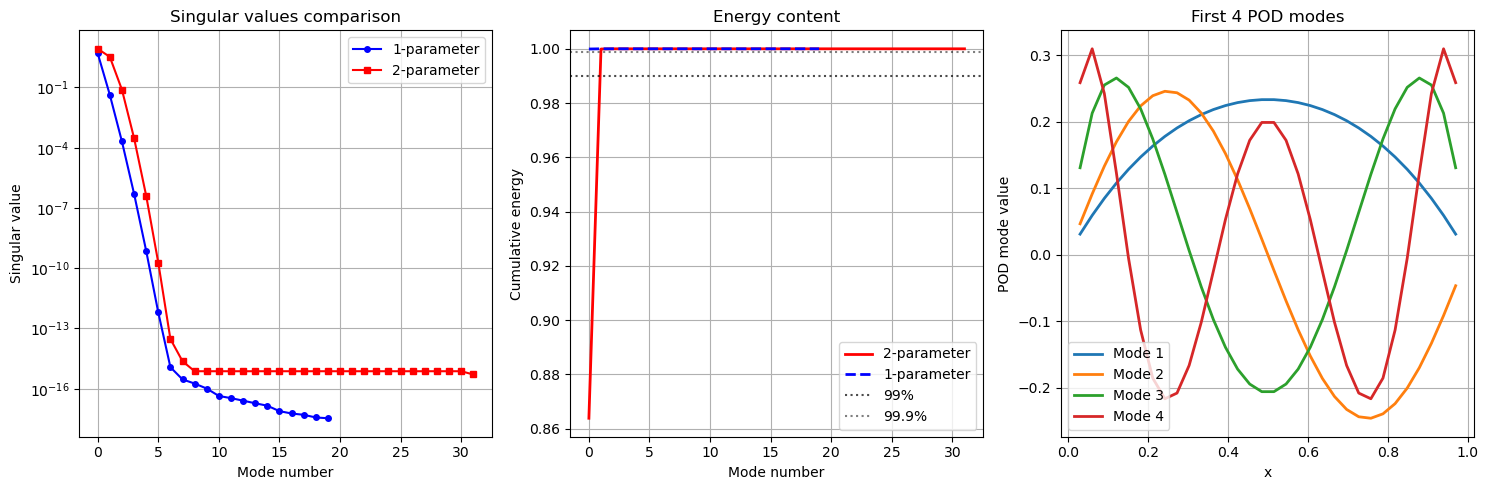

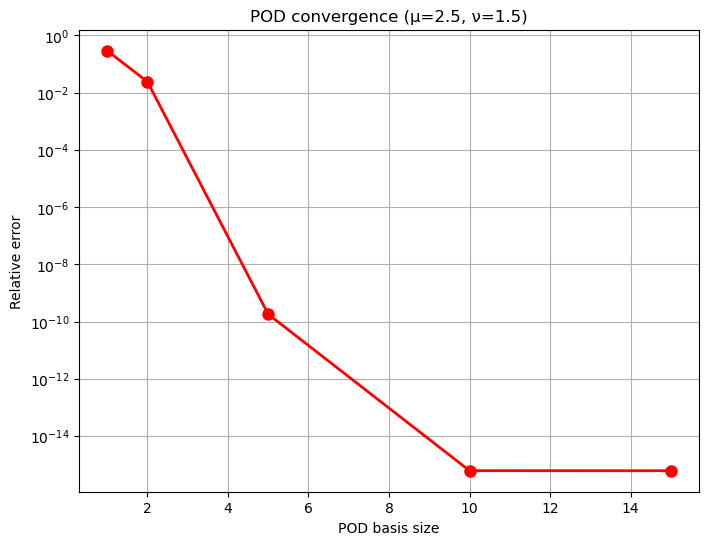

=== Exercise 6 Results ===
Extended problem singular values: 32 total
Modes for 99% energy (1-param): 1
Modes for 99% energy (2-param): 2
Modes for 99.9% energy (1-param): 1
Modes for 99.9% energy (2-param): 2
Test parameter: μ=2.5, ν=1.5
POD errors for different ranks: [np.float64(0.2919056413852449), np.float64(0.023999002435975938), np.float64(1.8015599421025476e-10), np.float64(6.136168560684614e-16), np.float64(6.112686010042368e-16)]


In [11]:
# === Your turn (student cell) ===
# Apply POD to the extended 2-parameter problem

# TODO: Compute POD decomposition
# U_ext, s_ext = pod_basis(S_ext, S_ext.shape[1])  # Full decomposition first
U_ext, s_ext = pod_basis(S_ext, S_ext.shape[1])

# TODO: Analyze singular values
plt.figure(figsize=(15, 5))

# Plot 1: Singular values comparison
plt.subplot(1, 3, 1)
# TODO: Plot singular values for both 1-param and 2-param cases
# plt.semilogy(s, 'b-o', label='1-parameter', markersize=4)
# plt.semilogy(s_ext, 'r-s', label='2-parameter', markersize=4)
# plt.xlabel('Mode number')
# plt.ylabel('Singular value')
# plt.title('Singular values comparison')
# plt.legend()
# plt.grid(True)
plt.semilogy(s, 'b-o', label='1-parameter', markersize=4)
plt.semilogy(s_ext, 'r-s', label='2-parameter', markersize=4)
plt.xlabel('Mode number')
plt.ylabel('Singular value')
plt.title('Singular values comparison')
plt.legend()
plt.grid(True)

# Plot 2: Cumulative energy
plt.subplot(1, 3, 2)
# TODO: Compute and plot cumulative energy for extended problem
# cumulative_energy_ext = np.cumsum(s_ext**2) / np.sum(s_ext**2)
# plt.plot(cumulative_energy_ext, 'r-', linewidth=2, label='2-parameter')
# plt.plot(cumulative_energy, 'b--', linewidth=2, label='1-parameter')
# plt.axhline(y=0.99, color='k', linestyle=':', alpha=0.7, label='99%')
# plt.axhline(y=0.999, color='k', linestyle=':', alpha=0.5, label='99.9%')
# plt.xlabel('Mode number')
# plt.ylabel('Cumulative energy')
# plt.title('Energy content')
# plt.legend()
# plt.grid(True)
cumulative_energy_ext = np.cumsum(s_ext**2) / np.sum(s_ext**2)
plt.plot(cumulative_energy_ext, 'r-', linewidth=2, label='2-parameter')
plt.plot(cumulative_energy, 'b--', linewidth=2, label='1-parameter')
plt.axhline(y=0.99, color='k', linestyle=':', alpha=0.7, label='99%')
plt.axhline(y=0.999, color='k', linestyle=':', alpha=0.5, label='99.9%')
plt.xlabel('Mode number')
plt.ylabel('Cumulative energy')
plt.title('Energy content')
plt.legend()
plt.grid(True)

# Plot 3: First few POD modes
plt.subplot(1, 3, 3)
# TODO: Visualize first 4 POD modes
# for i in range(4):
#     plt.plot(x_ext, U_ext[:, i], label=f'Mode {i+1}', linewidth=2)
# plt.xlabel('x')
# plt.ylabel('POD mode value')
# plt.title('First 4 POD modes')
# plt.legend()
# plt.grid(True)
for i in range(4):
    plt.plot(x_ext, U_ext[:, i], label=f'Mode {i+1}', linewidth=2)
plt.xlabel('x')
plt.ylabel('POD mode value')
plt.title('First 4 POD modes')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# TODO: Find modes needed for different energy levels
# modes_99_ext = None   # TODO: np.argmax(cumulative_energy_ext >= 0.99) + 1
# modes_999_ext = None  # TODO: np.argmax(cumulative_energy_ext >= 0.999) + 1
modes_99_ext = np.argmax(cumulative_energy_ext >= 0.99) + 1
modes_999_ext = np.argmax(cumulative_energy_ext >= 0.999) + 1

# TODO: Test POD performance on extended problem
# Choose a test parameter combination not in training set
mu_test_ext = 2.5
nu_test_ext = 1.5

# Test different POD basis sizes
test_ranks = [1, 2, 5, 10, min(15, len(s_ext))]
pod_errors_ext = []

for r_test in test_ranks:
    # TODO: Build POD basis of size r_test
    U_pod_ext = U_ext[:, :r_test]
    
    # TODO: Compute full and reduced solutions
    u_full_test = solve_full_extended(mu_test_ext, nu_test_ext, K_ext, I_ext, f_base_ext, f_osc_ext)
    u_rb_test, _ = rb_solve_extended(mu_test_ext, nu_test_ext, U_pod_ext, K_ext, I_ext, f_base_ext, f_osc_ext)
    
    # TODO: Compute relative error
    _, rel_error_test = project_error(u_full_test, u_rb_test)
    pod_errors_ext.append(rel_error_test)

# TODO: Plot POD convergence for extended problem
plt.figure(figsize=(8, 6))
# plt.semilogy(test_ranks, pod_errors_ext, 'ro-', linewidth=2, markersize=8)
# plt.xlabel('POD basis size')
# plt.ylabel('Relative error')
# plt.title(f'POD convergence (μ={mu_test_ext}, ν={nu_test_ext})')
# plt.grid(True)
# plt.show()
plt.semilogy(test_ranks, pod_errors_ext, 'ro-', linewidth=2, markersize=8)
plt.xlabel('POD basis size')
plt.ylabel('Relative error')
plt.title(f'POD convergence (μ={mu_test_ext}, ν={nu_test_ext})')
plt.grid(True)
plt.show()

print("=== Exercise 6 Results ===")
print(f"Extended problem singular values: {len(s_ext)} total")
print(f"Modes for 99% energy (1-param): {modes_99}")
print(f"Modes for 99% energy (2-param): {modes_99_ext}")
print(f"Modes for 99.9% energy (1-param): {modes_999}")
print(f"Modes for 99.9% energy (2-param): {modes_999_ext}")
print(f"Test parameter: μ={mu_test_ext}, ν={nu_test_ext}")
print(f"POD errors for different ranks: {pod_errors_ext}")

### Exercise 7 — Greedy for Multi-Parameter Problem (20 min)

Implement a greedy algorithm for the 2-parameter problem. This is more challenging because you need to search over the 2D parameter space!

**Tasks:**
1. Adapt the greedy algorithm for 2-parameter space $(\mu, \nu)$
2. Define an appropriate error estimator for the extended problem
3. Run the greedy algorithm and compare with POD
4. Visualize the selected parameters in the 2D parameter space
5. Compare computational efficiency

**Algorithm adaptation:**
- **Training set**: All combinations of $(\mu, \nu)$ from your parameter ranges
- **Error estimator**: Extend the residual-based estimator for the new RHS structure
- **Selection criterion**: Find $(\mu^*, \nu^*)$ that maximizes the estimator
- **Basis enrichment**: Add solution $u(\mu^*, \nu^*)$ to the basis

**Challenges:**
- Larger parameter space means more combinations to evaluate
- Error estimator needs to handle the new affine structure
- Visualization of selected parameters in 2D

In [ ]:
# === Your turn (student cell) ===
# Implement greedy algorithm for 2-parameter problem

def estimator_extended(u_rb, mu, nu, K, I, f_base, f_osc, lminK):
    """
    Error estimator for extended problem with affine RHS structure.
    
    For the extended problem: (mu*K + I) u = f_base + nu*f_osc
    Residual: r = f_base + nu*f_osc - (mu*K + I) @ u_rb
    """
    # TODO: Implement extended error estimator
    # Hint: r = f_base + nu*f_osc - (mu*K + I) @ u_rb
    # Hint: residual_norm = np.linalg.norm(r, 2)
    # Hint: alpha_lb = alpha_LB(mu, lminK)  # Same coercivity bound
    # return residual_norm / alpha_lb
    pass


def greedy_extended(param_combinations, K, I, f_base, f_osc, lminK, tol=1e-6, max_basis=20, verbose=True):
    """
    Greedy algorithm for 2-parameter problem.
    
    Parameters:
        param_combinations: list of (mu, nu) tuples for training
        Other parameters: system matrices and tolerances
    
    Returns:
        U: greedy basis matrix
        selected_params: list of selected (mu, nu) parameters
        estimator_history: convergence history
    """
    # TODO: Initialize with a parameter from the middle of the ranges
    # Find middle indices for mu and nu ranges
    n_mu = len(mu_ext)
    n_nu = len(nu_ext)
    mid_idx = (n_mu // 2) * n_nu + (n_nu // 2)  # Middle combination
    mu0, nu0 = param_combinations[mid_idx]
    
    # TODO: Compute initial solution and basis
    # u0 = solve_full_extended(mu0, nu0, K, I, f_base, f_osc)
    # U = orthonormalize(u0, None)[:, None]
    
    selected_params = [(mu0, nu0)]
    estimator_history = []
    
    if verbose:
        print(f"[Greedy Extended] Starting with μ={mu0:.3f}, ν={nu0:.3f}")
    
    # TODO: Main greedy loop
    for iteration in range(1, max_basis + 1):
        # TODO: Compute estimator for all parameter combinations
        estimators = []
        # for mu, nu in param_combinations:
        #     u_rb, _ = rb_solve_extended(mu, nu, U, K, I, f_base, f_osc)
        #     est = estimator_extended(u_rb, mu, nu, K, I, f_base, f_osc, lminK)
        #     estimators.append(est)
        
        # TODO: Find parameter combination with maximum estimator
        # idx_max = np.argmax(estimators)
        # mu_star, nu_star = param_combinations[idx_max]
        # max_estimator = estimators[idx_max]
        
        estimator_history.append(max_estimator)
        
        if verbose:
            print(f"[Greedy Extended] Iteration {iteration}: max est = {max_estimator:.3e} at μ={mu_star:.3f}, ν={nu_star:.3f}")
        
        # TODO: Check stopping criterion
        # if max_estimator < tol:
        #     if verbose:
        #         print(f"[Greedy Extended] Converged at iteration {iteration}")
        #     break
        
        # TODO: Enrich basis
        # u_star = solve_full_extended(mu_star, nu_star, K, I, f_base, f_osc)
        # v_new = orthonormalize(u_star, U)
        # if v_new is None:
        #     if verbose:
        #         print(f"[Greedy Extended] Linear dependence at iteration {iteration}")
        #     break
        # U = np.column_stack([U, v_new])
        
        selected_params.append((mu_star, nu_star))
    
    return U, selected_params, np.array(estimator_history)


# TODO: Run the extended greedy algorithm
print("Running greedy algorithm for 2-parameter problem...")
# U_greedy_ext, selected_ext, history_ext = greedy_extended(
#     param_combinations_ext, K_ext, I_ext, f_base_ext, f_osc_ext, lminK_ext, 
#     tol=1e-6, max_basis=20, verbose=True
# )

# TODO: Visualize results
plt.figure(figsize=(15, 5))

# Plot 1: Greedy convergence
plt.subplot(1, 3, 1)
# plt.semilogy(range(1, len(history_ext)+1), history_ext, 'go-', linewidth=2, markersize=6)
# plt.xlabel('Greedy iteration')
# plt.ylabel('Maximum estimator')
# plt.title('Greedy convergence (2-param)')
# plt.grid(True)

# Plot 2: Selected parameters in 2D space
plt.subplot(1, 3, 2)
# mu_selected = [p[0] for p in selected_ext]
# nu_selected = [p[1] for p in selected_ext]
# 
# # Plot all training parameters as background
# mu_all = [p[0] for p in param_combinations_ext]
# nu_all = [p[1] for p in param_combinations_ext]
# plt.scatter(mu_all, nu_all, c='lightgray', alpha=0.5, s=20, label='Training set')
# 
# # Plot selected parameters
# plt.scatter(mu_selected, nu_selected, c=range(len(mu_selected)), 
#             cmap='viridis', s=100, edgecolor='black', linewidth=1, label='Selected')
# for i, (mu_s, nu_s) in enumerate(selected_ext):
#     plt.annotate(f'{i+1}', (mu_s, nu_s), xytext=(5, 5), textcoords='offset points', fontsize=8)
# 
# plt.xlabel('μ (diffusion)')
# plt.ylabel('ν (oscillating amplitude)')
# plt.title('Selected parameters')
# plt.legend()
# plt.grid(True)

# Plot 3: POD vs Greedy comparison for extended problem
plt.subplot(1, 3, 3)
# Compare performance on a test parameter
# mu_test2, nu_test2 = 5.0, -1.0
# test_ranks_ext = range(1, min(U_greedy_ext.shape[1], U_ext.shape[1]) + 1)
# 
# pod_errors_comp = []
# greedy_errors_comp = []
# 
# for r in test_ranks_ext:
#     # POD error
#     U_pod_r = U_ext[:, :r]
#     u_full_comp = solve_full_extended(mu_test2, nu_test2, K_ext, I_ext, f_base_ext, f_osc_ext)
#     u_pod_comp, _ = rb_solve_extended(mu_test2, nu_test2, U_pod_r, K_ext, I_ext, f_base_ext, f_osc_ext)
#     _, rel_pod = project_error(u_full_comp, u_pod_comp)
#     pod_errors_comp.append(rel_pod)
#     
#     # Greedy error
#     if r <= U_greedy_ext.shape[1]:
#         U_greedy_r = U_greedy_ext[:, :r]
#         u_greedy_comp, _ = rb_solve_extended(mu_test2, nu_test2, U_greedy_r, K_ext, I_ext, f_base_ext, f_osc_ext)
#         _, rel_greedy = project_error(u_full_comp, u_greedy_comp)
#         greedy_errors_comp.append(rel_greedy)
#     else:
#         greedy_errors_comp.append(np.nan)
# 
# plt.semilogy(test_ranks_ext, pod_errors_comp, 'b-o', label='POD', linewidth=2)
# valid_greedy = [e for e in greedy_errors_comp if not np.isnan(e)]
# plt.semilogy(range(1, len(valid_greedy)+1), valid_greedy, 'r-s', label='Greedy', linewidth=2)
# plt.xlabel('Basis size')
# plt.ylabel('Relative error')
# plt.title(f'POD vs Greedy\n(μ={mu_test2}, ν={nu_test2})')
# plt.legend()
# plt.grid(True)

plt.tight_layout()
plt.show()

print("=== Exercise 7 Results ===")
# print(f"Greedy basis size: {U_greedy_ext.shape[1]}")
# print(f"Selected parameters: {len(selected_ext)}")
# print(f"Final estimator: {history_ext[-1]:.3e}")
# print(f"Training set size: {len(param_combinations_ext)}")
print("Extended greedy algorithm implementation complete!")